**INTRODUCTION AND DATA EXPLANATION**

In this project I'm going to be examining data from ourworldindata.org, downloaded through Kaggle <a href="https://www.kaggle.com/datasets/bhavikjikadara/entire-world-educational-data/data">here</a>. This data looks at various aspects of education globally as well as things that may impact or be impacted by education standards, from school completion rates to unemployment. I'm looking into the following research questions as a starting point: 

- How do birth rates and unemployment rates correlate with education outcomes like literacy rates and school completion rates?
- To what extent are higher education levels associated with lower unemployment rates? 
- Are there specific geographic patterns that emerge when mapping educational disparities?
- What are the key factors that predict higher literacy rates and education completion?
- What circumstances might contribute to regional disparities in academic achievement or attendance?

I added a column into this dataset myself with geographic regions, because in prior projects I've found it very useful to group by region rather than just country. I used the common geopolitical groupings, with the following of note:
- Combined North Africa and the Middle East
- Central Asia (i.e. Kazakhstan, Azerbaijan) is included in Asia
- Central America and the Caribbean are included in North America

In this notebook I'm going to do the EDA, visualization and modeling, and the Tableau dashboard and my written report will be separate.

<b>Important note on data limitations:</b> The author of this dataset compiled it from the source in such a way that there is a lot of missing data, so some regions or countries can't be evaluated in certain contexts (i.e. Oceania with school completion rates), and some things may appear as outliers when they ordinarily wouldn't be. The large number of NaNs also made the ML models somewhat unreliable. This is a personal project intended for practicing process and technique; normally this dataset would be fairly limiting and it would be worth seeking more complete data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import xgboost as xgb
from xgboost import plot_importance
import seaborn as sns
from scipy import stats
import warnings

%matplotlib inline
sns.set(rc = {'figure.figsize':(25,8)}, font_scale=1.5)
warnings.filterwarnings('ignore')

**CLEANING/EXAMINING DATA**

In [2]:
df = pd.read_csv('global_education_data.csv', encoding='latin1')
df.head()

,Countries and areas,Region,Latitude,Longitude,OOSR_Pre0Primary_Age_Male,OOSR_Pre0Primary_Age_Female,OOSR_Primary_Age_Male,OOSR_Primary_Age_Female,OOSR_Lower_Secondary_Age_Male,OOSR_Lower_Secondary_Age_Female,...,Primary_End_Proficiency_Reading,Primary_End_Proficiency_Math,Lower_Secondary_End_Proficiency_Reading,Lower_Secondary_End_Proficiency_Math,Youth_15_24_Literacy_Rate_Male,Youth_15_24_Literacy_Rate_Female,Birth_Rate,Gross_Primary_Education_Enrollment,Gross_Tertiary_Education_Enrollment,Unemployment_Rate
0,Afghanistan,N Africa Mid East,33.939110,67.709953,0,0,0,0,0,0,...,13,11,0,0,74,56,32.49,104.0,9.7,11.12
1,Albania,Europe,41.153332,20.168331,4,2,6,3,6,1,...,0,0,48,58,99,100,11.78,107.0,55.0,12.33
2,Algeria,N Africa Mid East,28.033886,1.659626,0,0,0,0,0,0,...,0,0,21,19,98,97,24.28,109.9,51.4,11.70
3,Andorra,Europe,42.506285,1.521801,0,0,0,0,0,0,...,0,0,0,0,0,0,7.20,106.4,0.0,0.00
4,Angola,SS Africa,11.202692,17.873887,31,39,0,0,0,0,...,0,0,0,0,0,0,40.73,113.5,9.3,6.89


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Countries and areas                      202 non-null    object 
 1   Region                                   201 non-null    object 
 2   Latitude                                 202 non-null    float64
 3   Longitude                                202 non-null    float64
 4   OOSR_Pre0Primary_Age_Male                202 non-null    int64  
 5   OOSR_Pre0Primary_Age_Female              202 non-null    int64  
 6   OOSR_Primary_Age_Male                    202 non-null    int64  
 7   OOSR_Primary_Age_Female                  202 non-null    int64  
 8   OOSR_Lower_Secondary_Age_Male            202 non-null    int64  
 9   OOSR_Lower_Secondary_Age_Female          202 non-null    int64  
 10  OOSR_Upper_Secondary_Age_Male            202 non-n

In [4]:
df.duplicated().sum()

0

There are no nulls or duplicates here and the dataframe looks in order, but I'm going to make the columns lowercase for ease of use. I also found an entry with a gibberish name "Sï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿" and there's no way of telling what this was meant to be (it also says that in the original CSV), so I'll remove the row. I'm also going to rename "countries and areas" to "country".

In [5]:
df.columns = df.columns.str.lower()

In [6]:
#df.loc[155]

df = df.drop(155)
df = df.reset_index(drop = True)
# confirm the drop
#df.loc[155]

In [7]:
df = df.rename(columns={'countries and areas' : 'country'})

I'm also going to combine the OOSR and completion rates for upper and lower secondary into one OOSR and completion rate for males and females respectively, because the upper/lower distinction isn't relevant for this and just adds unnecessary complexity. I'll do this by averaging them because these are percentages not counts. I'm also going to drop the pre-primary columns and grade 2 and 3 reading and math proficiency.

In [8]:
df['oosr_secondary_age_male'] = (df['oosr_lower_secondary_age_male'] + df['oosr_upper_secondary_age_male']) / 2
df['oosr_secondary_age_female'] = (df['oosr_lower_secondary_age_female'] + df['oosr_upper_secondary_age_female']) / 2

df['completion_rate_secondary_age_male'] = (df['completion_rate_lower_secondary_male'] + df['completion_rate_upper_secondary_male']) / 2
df['completion_rate_secondary_age_female'] = (df['completion_rate_lower_secondary_female'] + df['completion_rate_upper_secondary_female']) / 2

df1 = df.drop(['oosr_lower_secondary_age_male', 'oosr_upper_secondary_age_male', 'oosr_lower_secondary_age_female', 'oosr_upper_secondary_age_female', 'completion_rate_lower_secondary_male', 'completion_rate_lower_secondary_female', 'completion_rate_upper_secondary_male', 'completion_rate_upper_secondary_female', 'oosr_pre0primary_age_male', 'oosr_pre0primary_age_female','grade_2_3_proficiency_reading','grade_2_3_proficiency_math'], axis=1)

We can also see even from the df's head, but it becomes clearer after looking closer, that the dataset's author has chosen to use 0 as a placeholder for nulls. For example, it's basically inconcievable that high-poverty countries in Sub Saharan Africa have a female secondary-age OOSR of 0. This is a bad idea because if someone runs a null check and sees no nulls, they'll continue with summary statistics that will be highly skewed. So for this reason I'm going to change all incidences of 0 to NaN, because there are really no variables here where a value of 0 would make sense.

In [22]:
df1 = df1.replace(0, np.nan)
#export for dashboard use
df1.to_csv('Global Education_edited.csv')

Next I'm going to run through the df and check for outliers using the IQR method. It's easiest to do this with a function and some loops to reduce redundant code and save time.

In [10]:
def detect_outliers(df, column_name, threshold=1.5):
    # calculate the quartiles (Q1 and Q3) and the IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # define lower and upper bounds for outliers
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)

    # identify potential outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]

    return outliers[[column_name, 'country']]

In [11]:
# check that it works
#detect_outliers(df1, 'oosr_primary_age_male')

In [12]:
columns_to_check = df1.columns[4:]  # exclude the country/region names and geospatial data
outliers_dict = {}

for column in columns_to_check:
    outliers = detect_outliers(df1, column, threshold=1.5)
    outliers = outliers.sort_values(by=column, ascending=False)
    outliers_dict[column] = outliers

for column, outliers in outliers_dict.items():
    print(f"Outliers in column '{column}':")
    print(outliers)

Outliers in column 'oosr_primary_age_male':
     oosr_primary_age_male            country
166                   58.0        South Sudan
57                    56.0  Equatorial Guinea
58                    45.0            Eritrea
109                   38.0               Mali
129                   37.0              Niger
51                    32.0           Djibouti
170                   31.0              Sudan
156                   30.0            Senegal
Outliers in column 'oosr_primary_age_female':
     oosr_primary_age_female            country
166                     67.0        South Sudan
57                      55.0  Equatorial Guinea
58                      50.0            Eritrea
129                     45.0              Niger
109                     44.0               Mali
35                      35.0               Chad
51                      35.0           Djibouti
170                     35.0              Sudan
Outliers in column 'completion_rate_primary_male':
Empty DataFra

Some of the values that the function pulled are indeed incorrect, so I'll correct them below. In particular my eye was drawn to the gross education enrollment values over 100%, but upon researching it, that can happen if the number of children enrolled in schools at a particular level is higher than the number of children in the age group typically expected to be at that level, or because of early entry, repetition, or other things. But it's worth checking, and indeed some were wrong.

In [13]:
df1.loc[df['gross_primary_education_enrollment'] == 'Madagascar', 'gross_primary_education_enrollment'] = 76
df1.loc[df['gross_primary_education_enrollment'] == 'Malawi', 'gross_primary_education_enrollment'] = 126
df1.loc[df['gross_primary_education_enrollment'] == 'Nepal', 'gross_primary_education_enrollment'] = 119
df1.loc[df['country'] == 'San Marino', 'oosr_secondary_age_female'] = 1
df1.loc[df['country'] == 'San Marino', 'oosr_secondary_age_male'] = 1

In [14]:
df1.head()

,country,region,latitude,longitude,oosr_primary_age_male,oosr_primary_age_female,completion_rate_primary_male,completion_rate_primary_female,primary_end_proficiency_reading,primary_end_proficiency_math,...,youth_15_24_literacy_rate_male,youth_15_24_literacy_rate_female,birth_rate,gross_primary_education_enrollment,gross_tertiary_education_enrollment,unemployment_rate,oosr_secondary_age_male,oosr_secondary_age_female,completion_rate_secondary_age_male,completion_rate_secondary_age_female
0,Afghanistan,N Africa Mid East,33.939110,67.709953,NaN,NaN,67.0,40.0,13.0,11.0,...,74.0,56.0,32.49,104.0,9.7,11.12,22.0,34.5,40.5,20.0
1,Albania,Europe,41.153332,20.168331,6.0,3.0,94.0,96.0,NaN,NaN,...,99.0,100.0,11.78,107.0,55.0,12.33,13.5,8.0,87.0,88.5
2,Algeria,N Africa Mid East,28.033886,1.659626,NaN,NaN,93.0,93.0,NaN,NaN,...,98.0,97.0,24.28,109.9,51.4,11.70,NaN,NaN,35.5,51.0
3,Andorra,Europe,42.506285,1.521801,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.20,106.4,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,SS Africa,11.202692,17.873887,NaN,NaN,63.0,57.0,NaN,NaN,...,NaN,NaN,40.73,113.5,9.3,6.89,NaN,NaN,33.0,23.5


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country                                  201 non-null    object 
 1   region                                   201 non-null    object 
 2   latitude                                 201 non-null    float64
 3   longitude                                201 non-null    float64
 4   oosr_primary_age_male                    121 non-null    float64
 5   oosr_primary_age_female                  116 non-null    float64
 6   completion_rate_primary_male             106 non-null    float64
 7   completion_rate_primary_female           106 non-null    float64
 8   primary_end_proficiency_reading          44 non-null     float64
 9   primary_end_proficiency_math             49 non-null     float64
 10  lower_secondary_end_proficiency_reading  86 non-nu

**EDA**

In [101]:
sub1 = df1[['birth_rate', 'unemployment_rate', 'youth_15_24_literacy_rate_male', 'youth_15_24_literacy_rate_female', 'oosr_secondary_age_female', 'oosr_secondary_age_male']]

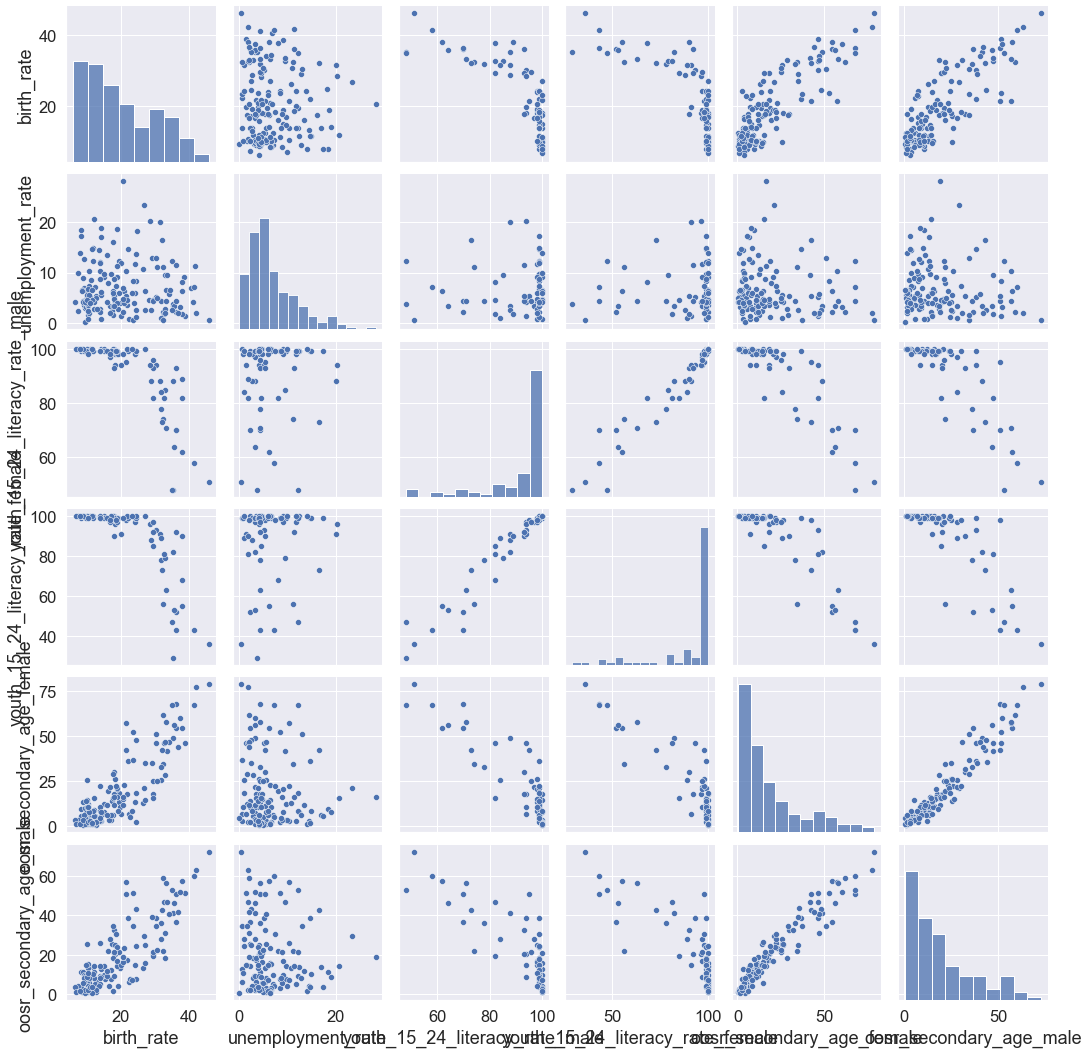

In [102]:
sns.pairplot(sub1)

A basic pairplot on some select variables shows us that the out of school rate positively correlates with the birth rate. The OOSR rate also negatively correlates with literacy. In examining the OOSR against unemployment, we see that a low OOSR indicates a low unemployment rate, and most data points are clustered in that region in scatterplots comparing those two. In general we also see that the out of school rates globally trend low, and literacy trends high for both males and females.

Now let's do some summary statistics to examine the composition and general positioning of some of these variables.

In [103]:
print(df1['youth_15_24_literacy_rate_male'].describe())
print(df1['youth_15_24_literacy_rate_female'].describe())

count     78.000000
mean      91.461538
std       13.286740
min       48.000000
25%       88.250000
50%       98.000000
75%       99.000000
max      100.000000
Name: youth_15_24_literacy_rate_male, dtype: float64
count     78.000000
mean      89.602564
std       17.786132
min       29.000000
25%       90.000000
50%       99.000000
75%      100.000000
max      100.000000
Name: youth_15_24_literacy_rate_female, dtype: float64


In [104]:
mean_oosr_regional_female = df1.groupby('region')['youth_15_24_literacy_rate_male'].mean()
mean_oosr_regional_male = df1.groupby('region')['youth_15_24_literacy_rate_female'].mean()
print(mean_oosr_regional_female, mean_oosr_regional_male)

region
Asia                 97.062500
Europe               99.583333
N Africa Mid East    89.636364
North America        98.000000
Oceania              98.000000
SS Africa            80.166667
South America        98.857143
Name: youth_15_24_literacy_rate_male, dtype: float64 region
Asia                 97.125000
Europe               99.750000
N Africa Mid East    87.818182
North America        98.800000
Oceania              98.666667
SS Africa            74.541667
South America        99.000000
Name: youth_15_24_literacy_rate_female, dtype: float64


These are quite high and fairly globally consistent, with the lowest being SS Africa, but even that is not too bad. This is also somewhat older data, as the mean youth literacy rate in 2022 was around 78.3%.

In [105]:
mean_completion_rate_female = df1.groupby('region')['completion_rate_secondary_age_female'].mean()
mean_completion_rate_male = df1.groupby('region')['completion_rate_secondary_age_male'].mean()
print(mean_completion_rate_female,  mean_completion_rate_male)

region
Asia                 66.568182
Europe               91.555556
N Africa Mid East    50.000000
North America        68.269231
Oceania              60.000000
SS Africa            27.871795
South America        72.500000
Name: completion_rate_secondary_age_female, dtype: float64 region
Asia                 64.704545
Europe               89.500000
N Africa Mid East    49.772727
North America        63.038462
Oceania              48.000000
SS Africa            31.051282
South America        67.650000
Name: completion_rate_secondary_age_male, dtype: float64


Very wide spread here with completion rates. A box plot would be good to examine this. I'm going to make a copy of the df and use the melt function to make gender a categorical variable so I can use it as the hue in plots. 

In [106]:
df_long_completion = df1.melt(id_vars=['region', 'country'], value_vars=['completion_rate_secondary_age_male', 'completion_rate_secondary_age_female'], 
                 var_name='gender', value_name='completion_rate_secondary')

df_long_completion['gender'] = df_long_completion['gender'].replace({'completion_rate_secondary_age_male': 'male', 'completion_rate_secondary_age_female': 'female'})

Text(0.5, 1.0, 'Secondary-Age School Completion Rate by Gender Across Regions')

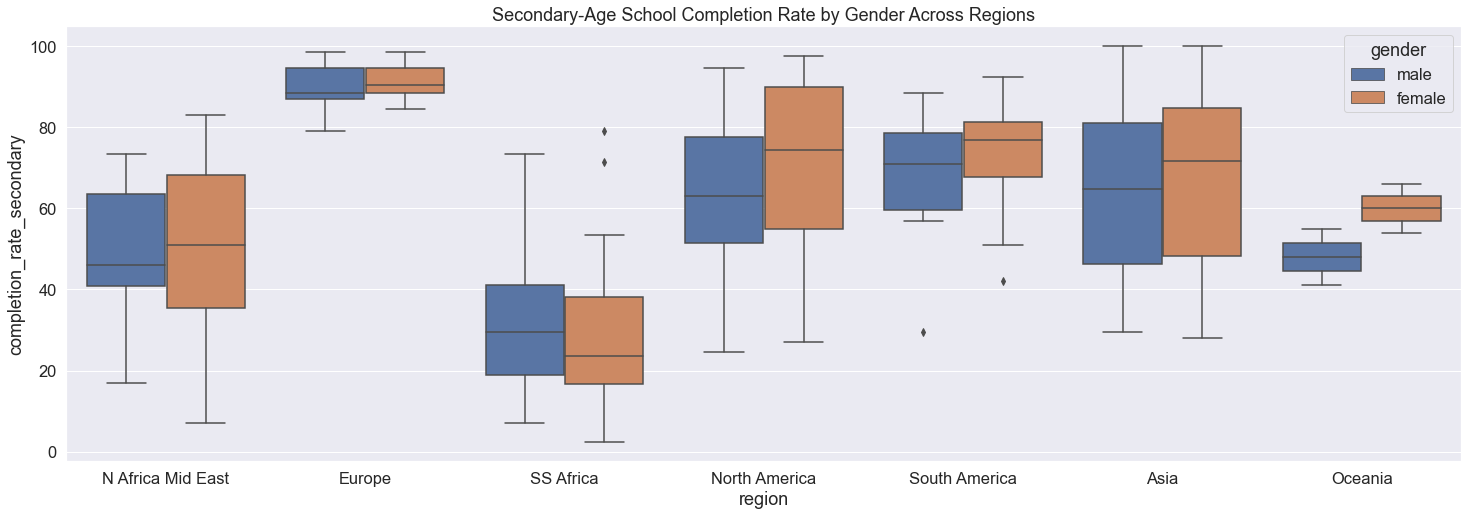

In [107]:
sns.boxplot(x='region', y='completion_rate_secondary', hue='gender', data=df_long_completion)
plt.title('Secondary-Age School Completion Rate by Gender Across Regions')

Here I'm particularly interested in the difference between male and female in Oceania.

In [108]:
Oceania_long = df_long_completion[df_long_completion['region'] == 'Oceania']
#Oceania_completion = Oceania_long[Oceania_long['completion_rate_secondary'].notna()]

In [109]:
Oceania_long

,region,country,gender,completion_rate_secondary
9,Oceania,Australia,male,NaN
41,Oceania,Cook Islands,male,NaN
62,Oceania,Fiji,male,NaN
93,Oceania,Kiribati,male,41.0
111,Oceania,Marshall Islands,male,NaN
115,Oceania,Micronesia,male,NaN
124,Oceania,Nauru,male,NaN
127,Oceania,New Zealand,male,NaN
131,Oceania,Niue,male,NaN
136,Oceania,Palau,male,NaN


The reason is that there isn't really any data for this in Oceania for some reason, so we won't consider Oceania in this instance.

In [110]:
average_male_literacy_rate = df1['youth_15_24_literacy_rate_male'].mean()
average_female_literacy_rate = df1['youth_15_24_literacy_rate_female'].mean()
print("Global avg male literacy rate: ", average_male_literacy_rate) 
print("Global avg female literacy rate: ", average_female_literacy_rate)

Global avg male literacy rate:  91.46153846153847
Global avg female literacy rate:  89.6025641025641


In [111]:
unemployment_rate = df1.groupby('region')['unemployment_rate'].mean()
print(unemployment_rate)

region
Asia                 4.515333
Europe               6.839744
N Africa Mid East    9.170870
North America        8.256316
Oceania              3.793750
SS Africa            6.984091
South America        7.580833
Name: unemployment_rate, dtype: float64


In [112]:
mean_secondary_completion_rate_female = df1.groupby('region')['completion_rate_secondary_age_female'].mean()
mean_secondary_completion_rate_male = df1.groupby('region')['completion_rate_secondary_age_male'].mean()
print(mean_secondary_completion_rate_female, mean_secondary_completion_rate_male)

region
Asia                 66.568182
Europe               91.555556
N Africa Mid East    50.000000
North America        68.269231
Oceania              60.000000
SS Africa            27.871795
South America        72.500000
Name: completion_rate_secondary_age_female, dtype: float64 region
Asia                 64.704545
Europe               89.500000
N Africa Mid East    49.772727
North America        63.038462
Oceania              48.000000
SS Africa            31.051282
South America        67.650000
Name: completion_rate_secondary_age_male, dtype: float64


In [113]:
print(df1['completion_rate_secondary_age_female'].describe())
print(df1['completion_rate_secondary_age_male'].describe())

count    106.000000
mean      53.377358
std       28.853226
min        2.500000
25%       29.500000
50%       51.250000
75%       79.375000
max      100.000000
Name: completion_rate_secondary_age_female, dtype: float64
count    106.000000
mean      52.636792
std       25.550001
min        7.000000
25%       31.125000
50%       50.250000
75%       73.375000
max      100.000000
Name: completion_rate_secondary_age_male, dtype: float64


In [114]:
print(df1['oosr_secondary_age_female'].describe())
print(df1['oosr_secondary_age_male'].describe())

count    154.000000
mean      18.639610
std       18.627102
min        0.500000
25%        4.500000
50%       12.000000
75%       25.500000
max       79.000000
Name: oosr_secondary_age_female, dtype: float64
count    153.000000
mean      18.882353
std       16.658308
min        0.500000
25%        5.500000
50%       14.000000
75%       26.000000
max       72.500000
Name: oosr_secondary_age_male, dtype: float64


In [115]:
mean_oosr_regional_female = df1.groupby('region')['oosr_secondary_age_female'].mean()
mean_oosr_regional_male = df1.groupby('region')['oosr_secondary_age_male'].mean()
print(mean_oosr_regional_female, mean_oosr_regional_male)

region
Asia                 14.075000
Europe                5.475610
N Africa Mid East    22.000000
North America        15.386364
Oceania              18.791667
SS Africa            42.533333
South America        11.681818
Name: oosr_secondary_age_female, dtype: float64 region
Asia                 17.894737
Europe                5.768293
N Africa Mid East    19.722222
North America        16.840909
Oceania              21.125000
SS Africa            39.400000
South America        13.772727
Name: oosr_secondary_age_male, dtype: float64


There's pretty significant spread here so again a box plot would be good.

In [116]:
df_long = df1.melt(id_vars='region', value_vars=['oosr_secondary_age_male', 'oosr_secondary_age_female'], 
                 var_name='gender', value_name='oosr_rate_secondary')

df_long['gender'] = df_long['gender'].replace({'oosr_secondary_age_male': 'male', 'oosr_secondary_age_female': 'female'})

Text(0.5, 1.0, 'Secondary-Age OOSR by Gender Across Regions')

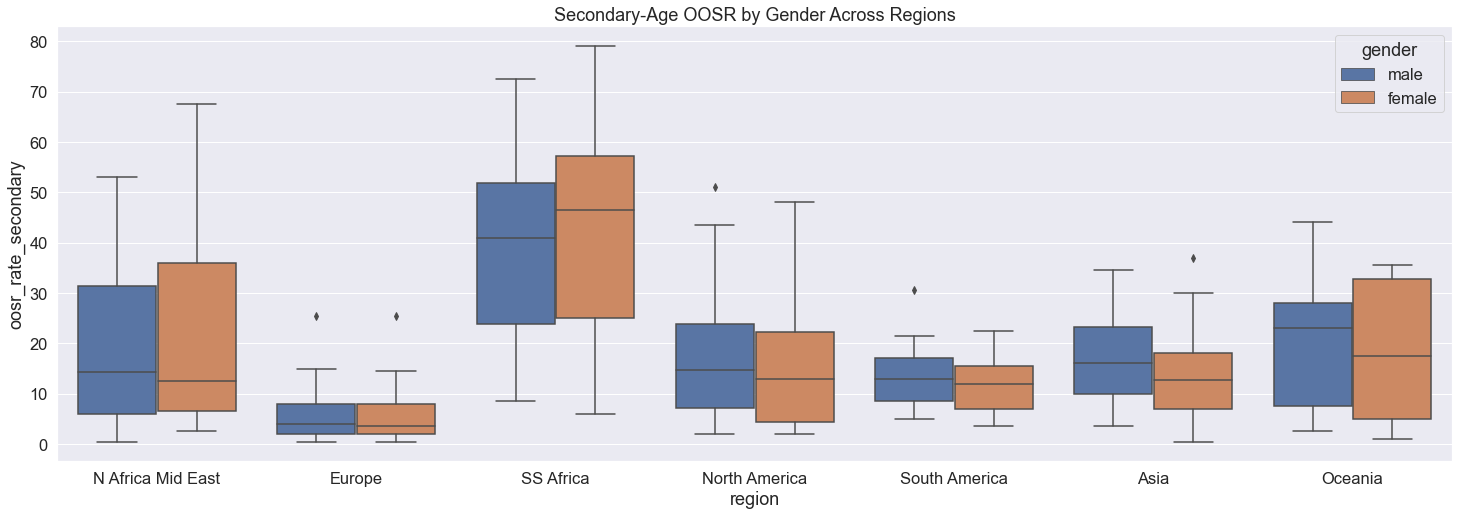

In [117]:
sns.boxplot(x='region', y='oosr_rate_secondary', hue='gender', data=df_long)
plt.title('Secondary-Age OOSR by Gender Across Regions')

It's clear here Africa has the overall highest dropout rate for both males and females and Europe has the lowest. Also interesting that the female OOSR is lower in NA-ME, SS Africa, and Oceania but higher in the Americas and Asia. Africa and NM-ME have some crazy spread. I just want to take a closer look at that. 

In [118]:
SSafrica = df1[df1['region'] == 'SS Africa']
SSafrica_ossr = SSafrica[SSafrica['oosr_secondary_age_female'].notna()]
#SSafrica['oosr_secondary_age_female'].describe()

[Text(0.5, 1.0, 'Highest and Lowest OOSR in SS Africa')]

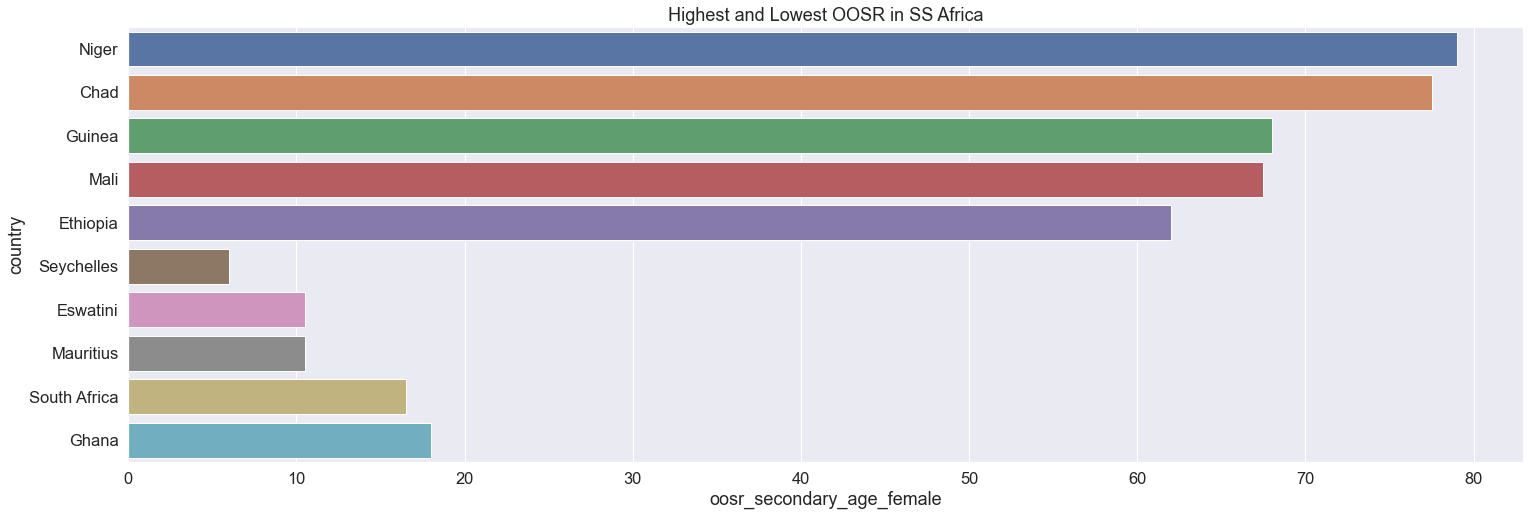

In [119]:
#sns.barplot(x = 'oosr_secondary_age_female', y = 'country', data = SSafrica)

top_5_oosr = SSafrica_ossr.nlargest(5, 'oosr_secondary_age_female')[['country', 'oosr_secondary_age_female']]
bottom_5_oosr = SSafrica_ossr.nsmallest(5, 'oosr_secondary_age_female')[['country', 'oosr_secondary_age_female']]
top_bottom_oosr = pd.concat([top_5_oosr, bottom_5_oosr])

sns.barplot(x='oosr_secondary_age_female', y='country', data=top_bottom_oosr).set(title='Highest and Lowest OOSR in SS Africa')

In [120]:
#north africa middle east subset
NA_ME = df1[df1['region'] == 'N Africa Mid East']
NA_ME_ossr = NA_ME[NA_ME['oosr_secondary_age_female'].notna()]

[Text(0.5, 1.0, 'Highest and Lowest OOSR in N Africa Mid East')]

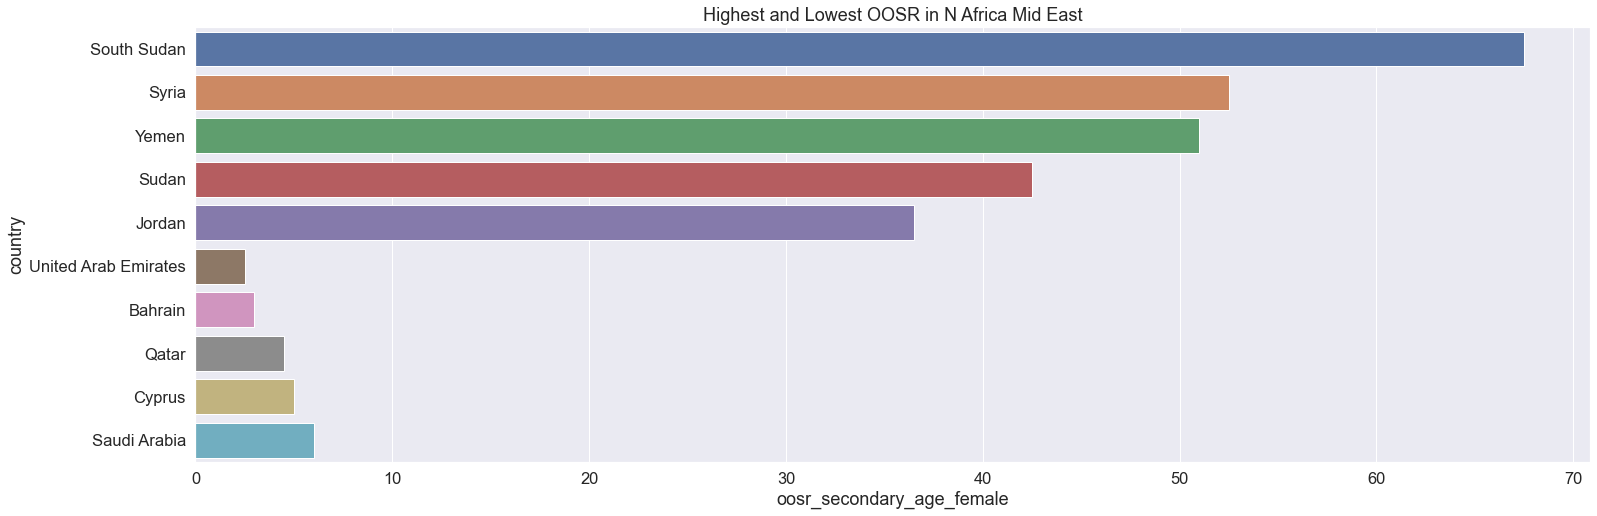

In [121]:
#sns.barplot(x = 'oosr_secondary_age_female', y = 'country', data = NA_ME_ossr)

top_5_oosr = NA_ME_ossr.nlargest(5, 'oosr_secondary_age_female')[['country', 'oosr_secondary_age_female']]
bottom_5_oosr = NA_ME_ossr.nsmallest(5, 'oosr_secondary_age_female')[['country', 'oosr_secondary_age_female']]
top_bottom_oosr = pd.concat([top_5_oosr, bottom_5_oosr])

sns.barplot(x='oosr_secondary_age_female', y='country', data=top_bottom_oosr).set(title='Highest and Lowest OOSR in N Africa Mid East')

In both cases there is a poverty/stability split between the top 5 and bottom 5 here. Ghana was interesting to see in the low OOSR plot, but it's one of the fastest growing economies in the world, so more access to education would be expected.

In [122]:
enrollment_data_long = df1.melt(id_vars=['region'], 
                               value_vars=['gross_primary_education_enrollment', 'gross_tertiary_education_enrollment'],
                               var_name='Enrollment Level', value_name='Enrollment Rate')

Text(0.5, 1.0, 'School Enrollment Across Regions')

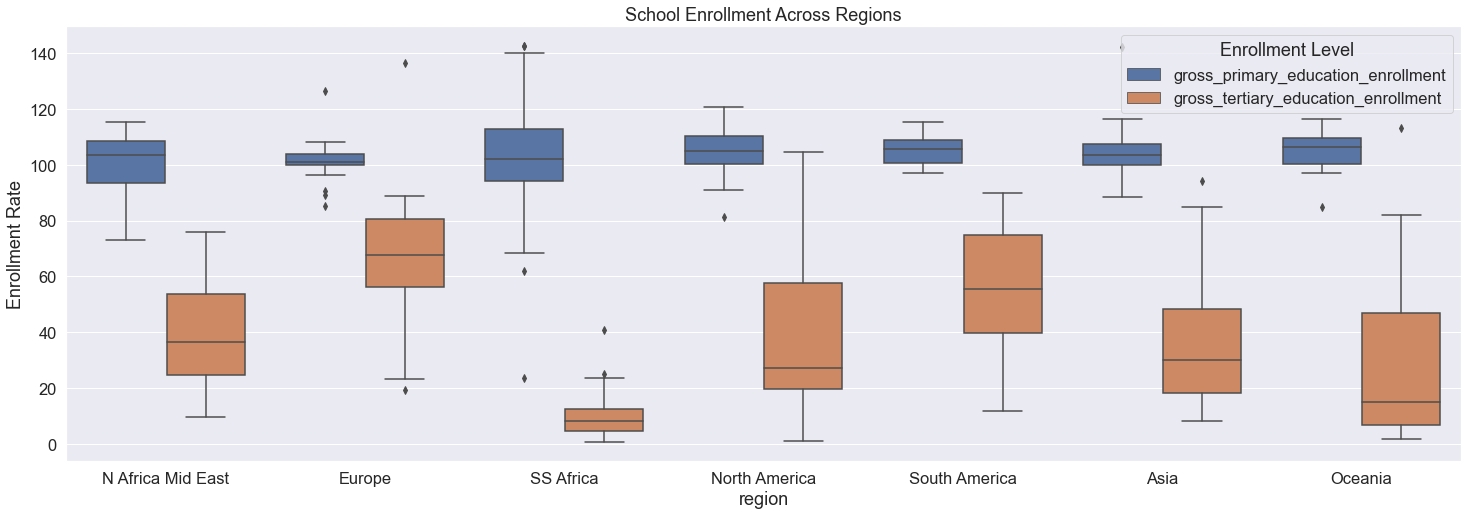

In [123]:
sns.boxplot(x='region', y='Enrollment Rate', hue='Enrollment Level', data=enrollment_data_long)
plt.title('School Enrollment Across Regions')

In [124]:
#examine outliers
ss_africa_lowest_tertiary = df1[df1['region'] == 'SS Africa'].nsmallest(1, 'gross_tertiary_education_enrollment')[['country', 'gross_tertiary_education_enrollment']]
print(ss_africa_lowest_tertiary)

europe_highest_tertiary = df1[df1['region'] == 'Europe'].nlargest(1, 'gross_tertiary_education_enrollment')[['country', 'gross_tertiary_education_enrollment']]
print(europe_highest_tertiary)

europe_highest_primary = df1[df1['region'] == 'Europe'].nlargest(1, 'gross_primary_education_enrollment')[['country', 'gross_primary_education_enrollment']]
print(europe_highest_primary)

asia_highest_tertiary = df1[df1['region'] == 'Asia'].nlargest(1, 'gross_tertiary_education_enrollment')[['country', 'gross_tertiary_education_enrollment']]
print(asia_highest_tertiary)

    country  gross_tertiary_education_enrollment
106  Malawi                                  0.8
   country  gross_tertiary_education_enrollment
70  Greece                                136.6
    country  gross_primary_education_enrollment
172  Sweden                               126.6
         country  gross_tertiary_education_enrollment
145  South Korea                                 94.3


In [125]:
primary_subset = df1[['completion_rate_secondary_age_female','completion_rate_secondary_age_male','oosr_secondary_age_female','oosr_secondary_age_male','unemployment_rate', 'birth_rate', 'gross_tertiary_education_enrollment', 'gross_primary_education_enrollment','youth_15_24_literacy_rate_female','youth_15_24_literacy_rate_male','completion_rate_primary_female','completion_rate_primary_male']]
primary_subset_corr = primary_subset.corr()

<AxesSubplot:>

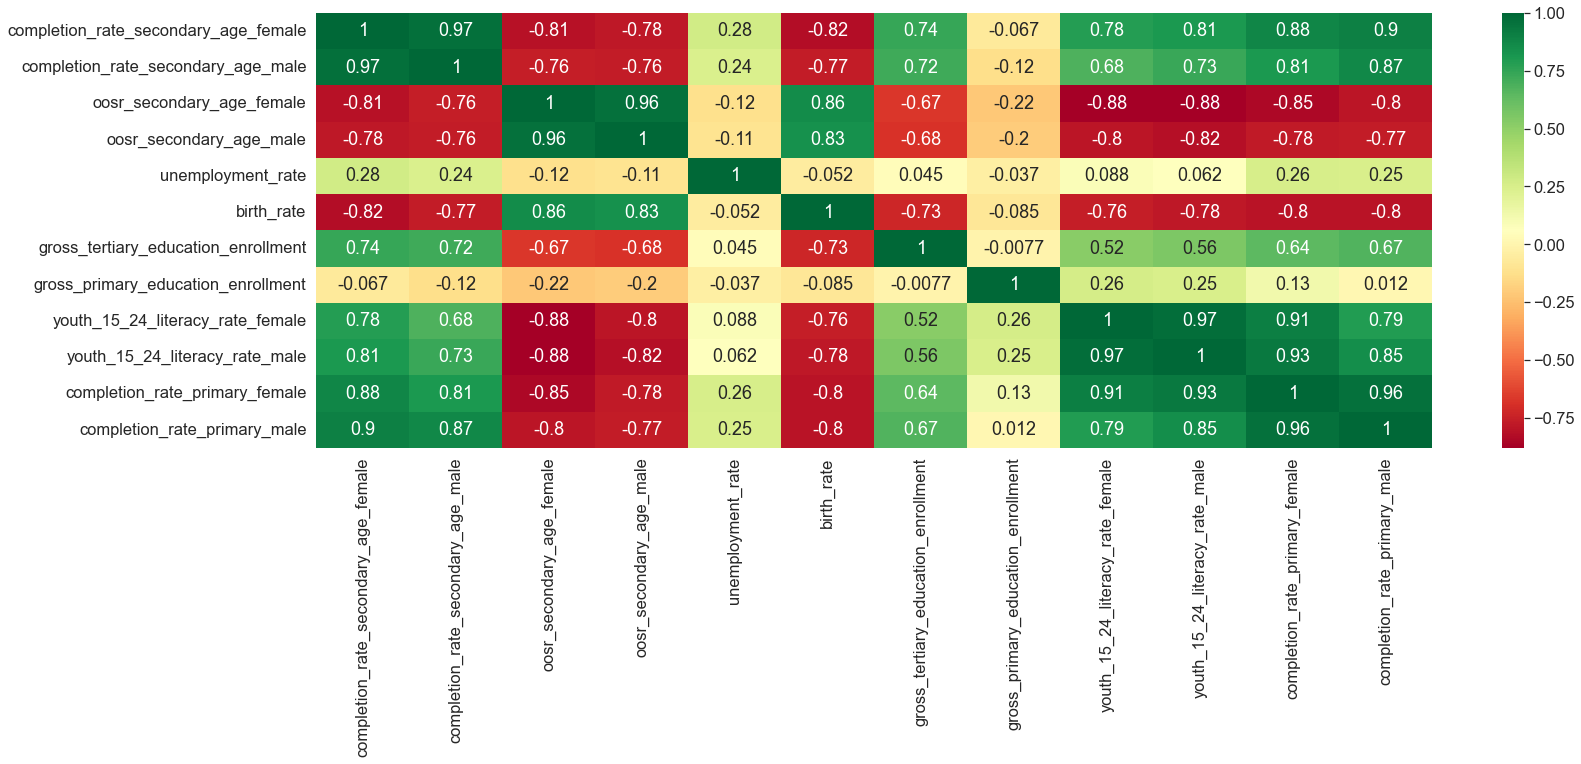

In [126]:
sns.heatmap(primary_subset_corr, annot=True, cmap='RdYlGn')

Some insights from this:  
- Completion rates and literacy rates are highly positively correlated. 
- Completion and literacy rates for males and females are closely to strongly correlated which indicates that in general they're pretty similar. 
- Gross Primary Education Enrollment doesn't strongly correlate with anything, while Gross Tertiary Education Enrollment has a somewhat strong (.5-.6ish) positive correlation to completion rate and literacy. I'm surprised it's not stronger. 
- Unemployment Rate doesn't strongly correlate to anything, though if we recall the above scatterplots, that was more of a clustering rather than a strongly linear relationship
- Birth rate is strongly negatively correlated to both male and female completion rate and tertiary school enrollment (obviously not primary school and there's no secondary category) as well as both male and female literacy. I think this is not necessarily causal in the case of males, and may be one factor in a general set of circumstances that affect young men.

**TARGETED VISUALIZATION**

**Question 1 - How do birth rates and unemployment rates correlate with education outcomes like literacy rates and school completion rates?**

In [127]:
#sub2 = df1[['birth_rate', 'unemployment_rate', 'youth_15_24_literacy_rate_male', 'completion_rate_secondary_age_male']]
#sns.pairplot(sub2)

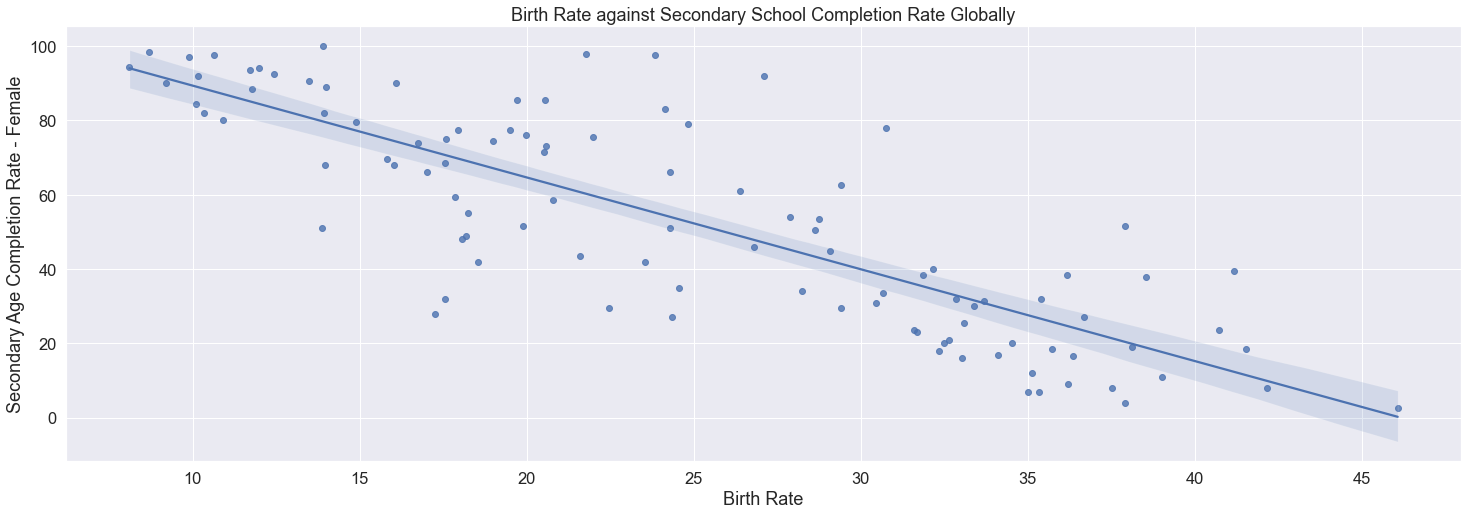

In [128]:
sns.regplot(x='birth_rate', y='completion_rate_secondary_age_female', data=df1).set(title='Birth Rate against Secondary School Completion Rate Globally', xlabel='Birth Rate', ylabel='Secondary Age Completion Rate - Female')
sns.set(rc = {'axes.facecolor':'white'},font_scale=1.5)

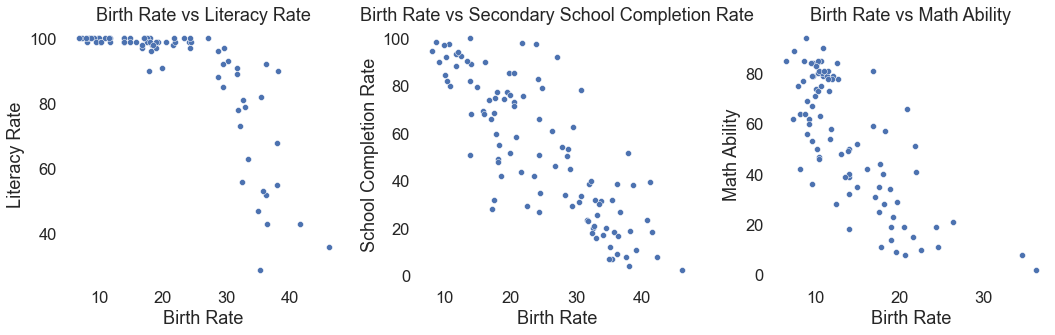

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# birth rate vs literacy rate
sns.scatterplot(x='birth_rate', y='youth_15_24_literacy_rate_female', data=df1, ax=axes[0])
axes[0].set_title('Birth Rate vs Literacy Rate')
axes[0].set_xlabel('Birth Rate')
axes[0].set_ylabel('Literacy Rate')

# birth rate vs school completion rate
sns.scatterplot(x='birth_rate', y='completion_rate_secondary_age_female', data=df1, ax=axes[1])
axes[1].set_title('Birth Rate vs Secondary School Completion Rate')
axes[1].set_xlabel('Birth Rate')
axes[1].set_ylabel('School Completion Rate')

# birth rate vs math ability
sns.scatterplot(x='birth_rate', y='lower_secondary_end_proficiency_math', data=df1, ax=axes[2])
axes[2].set_title('Birth Rate vs Math Ability')
axes[2].set_xlabel('Birth Rate')
axes[2].set_ylabel('Math Ability')

plt.tight_layout()
plt.show()

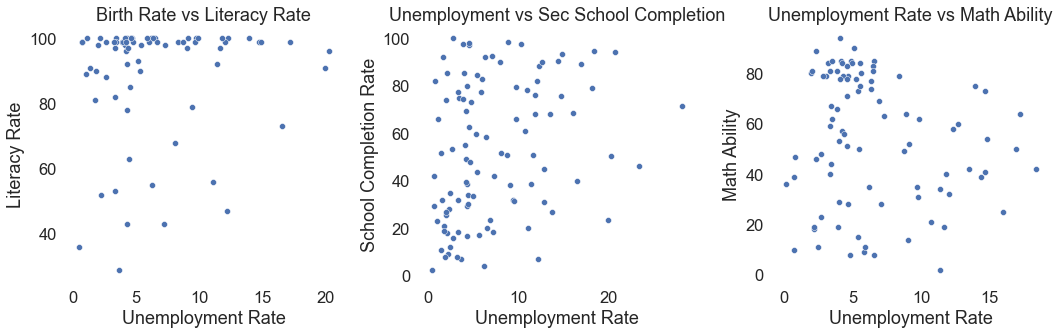

In [130]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# unemployment rate vs literacy rate
sns.scatterplot(x='unemployment_rate', y='youth_15_24_literacy_rate_female', data=df1, ax=axes[0])
axes[0].set_title('Birth Rate vs Literacy Rate')
axes[0].set_xlabel('Unemployment Rate')
axes[0].set_ylabel('Literacy Rate')

# unemployment rate vs school completion rate
sns.scatterplot(x='unemployment_rate', y='completion_rate_secondary_age_female', data=df1, ax=axes[1])
axes[1].set_title('Unemployment vs Sec School Completion')
axes[1].set_xlabel('Unemployment Rate')
axes[1].set_ylabel('School Completion Rate')

# birth rate vs math ability
sns.scatterplot(x='unemployment_rate', y='lower_secondary_end_proficiency_math', data=df1, ax=axes[2])
axes[2].set_title('Unemployment Rate vs Math Ability')
axes[2].set_xlabel('Unemployment Rate')
axes[2].set_ylabel('Math Ability')

plt.tight_layout()
plt.show()

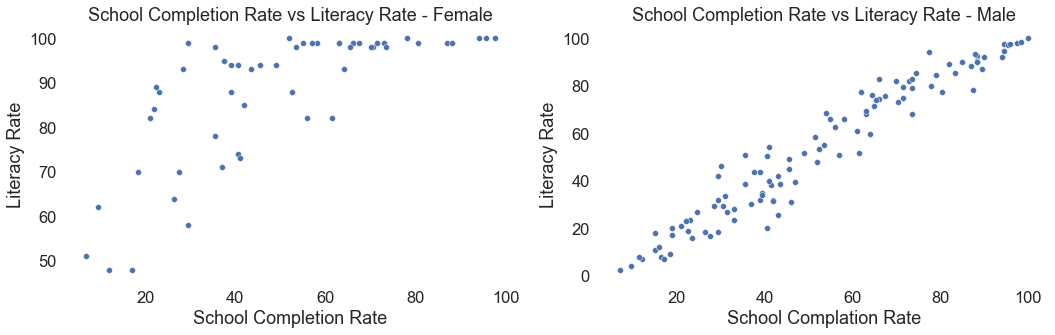

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# literacy rate vs school completion rate female
sns.scatterplot(x='completion_rate_secondary_age_male', y='youth_15_24_literacy_rate_male', data=df1, ax=axes[0])
axes[0].set_title('School Completion Rate vs Literacy Rate - Female')
axes[0].set_xlabel('School Completion Rate')
axes[0].set_ylabel('Literacy Rate')

# literacy rate vs school completion rate male
sns.scatterplot(x='completion_rate_secondary_age_male', y='completion_rate_secondary_age_female', data=df1, ax=axes[1])
axes[1].set_title('School Completion Rate vs Literacy Rate - Male')
axes[1].set_xlabel('School Complation Rate')
axes[1].set_ylabel('Literacy Rate')

plt.tight_layout()
plt.show()

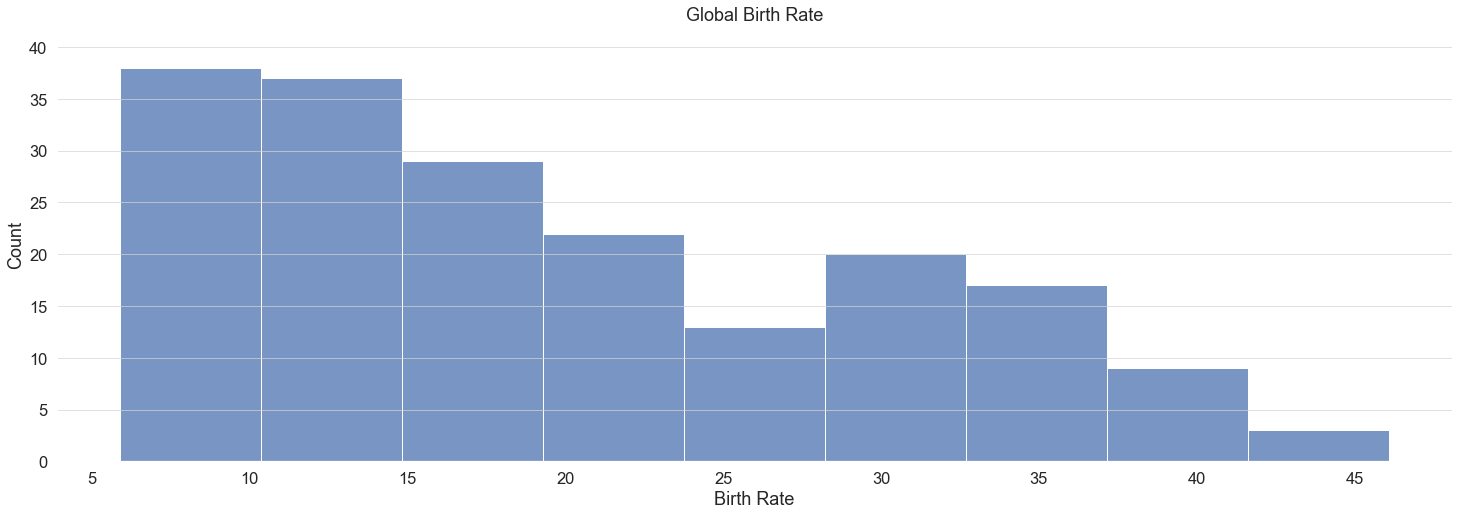

In [132]:
sns.histplot(x='birth_rate', data=df1).set(title='Global Birth Rate', xlabel='Birth Rate')
[plt.axhline(y, color='lightgray', linestyle='-', linewidth=0.7) for y in plt.yticks()[0]]
sns.set(rc = {'axes.facecolor':'white'},font_scale=1.5)

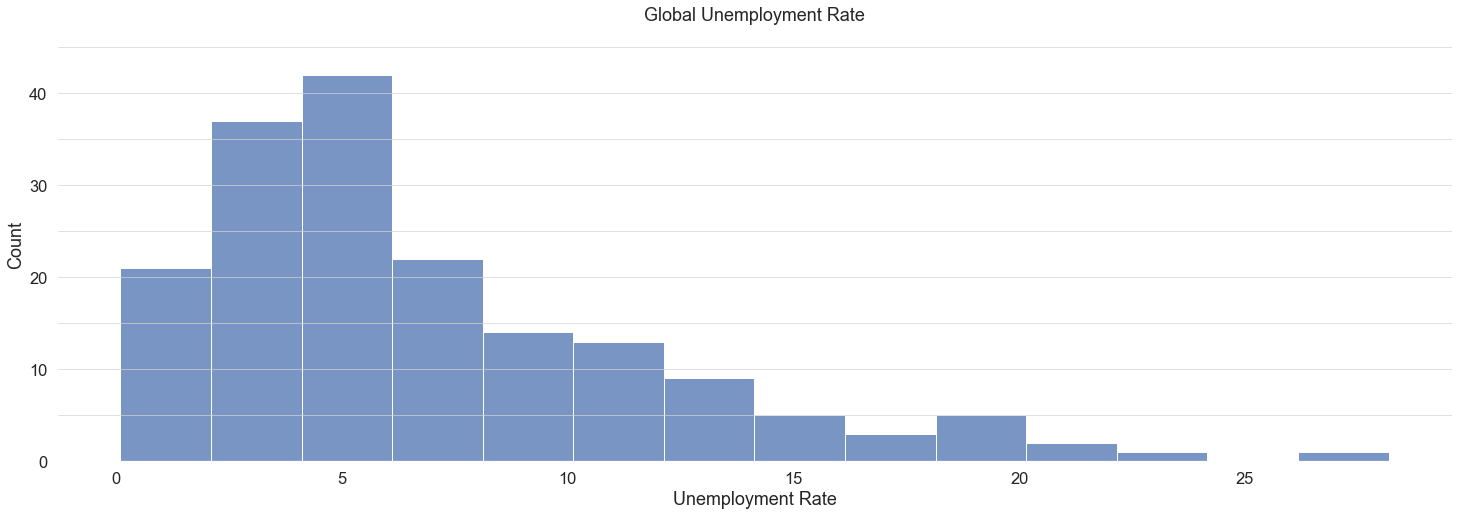

In [133]:
sns.histplot(x='unemployment_rate', data=df1).set(title='Global Unemployment Rate', xlabel='Unemployment Rate')
[plt.axhline(y, color='lightgray', linestyle='-', linewidth=0.7) for y in plt.yticks()[0]]
sns.set(rc = {'axes.facecolor':'white'},font_scale=1.5)

**Question 2 - To what extent are higher education levels associated with lower unemployment rates?**

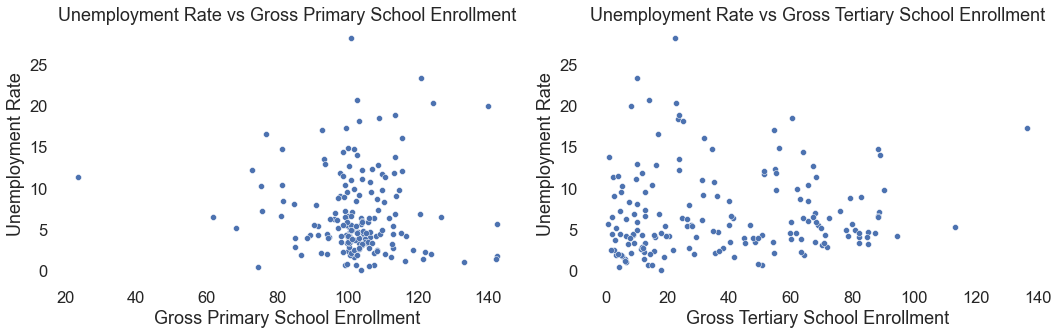

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# unemployment rate vs gross primary school enrollment
sns.scatterplot(x='gross_primary_education_enrollment', y='unemployment_rate', data=df1, ax=axes[0])
axes[0].set_title('Unemployment Rate vs Gross Primary School Enrollment')
axes[0].set_xlabel('Gross Primary School Enrollment')
axes[0].set_ylabel('Unemployment Rate')

# unemployment rate vs gross tertiary  school enrollment
sns.scatterplot(x='gross_tertiary_education_enrollment', y='unemployment_rate', data=df1, ax=axes[1])
axes[1].set_title('Unemployment Rate vs Gross Tertiary School Enrollment')
axes[1].set_xlabel('Gross Tertiary School Enrollment')
axes[1].set_ylabel('Unemployment Rate')

plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Highest and Lowest Unemployment Globally')]

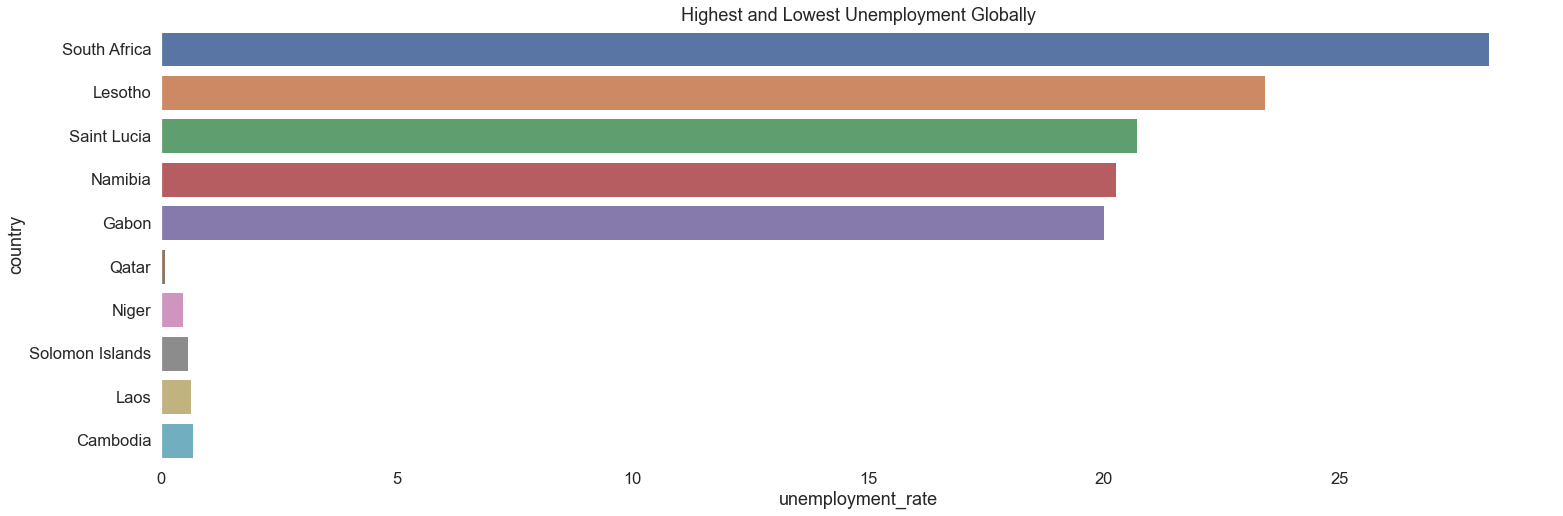

In [135]:
top_5_unemployment = df1.nlargest(5, 'unemployment_rate')[['country', 'unemployment_rate']]
bottom_5_unemployment = df1.nsmallest(5, 'unemployment_rate')[['country', 'unemployment_rate']]
top_bottom_oosr = pd.concat([top_5_unemployment, bottom_5_unemployment])

sns.barplot(x='unemployment_rate', y='country', data=top_bottom_oosr).set(title='Highest and Lowest Unemployment Globally')

**Question 3: Are there specific geographic patterns that emerge when mapping educational disparities?**

In [136]:
#Question 3
# Do double bar chart across regions for key educational metrics
# Geopandas to plot that geographically?

[Text(0.5, 1.0, 'Highest and Lowest Tertiary Education Enrollment Globally')]

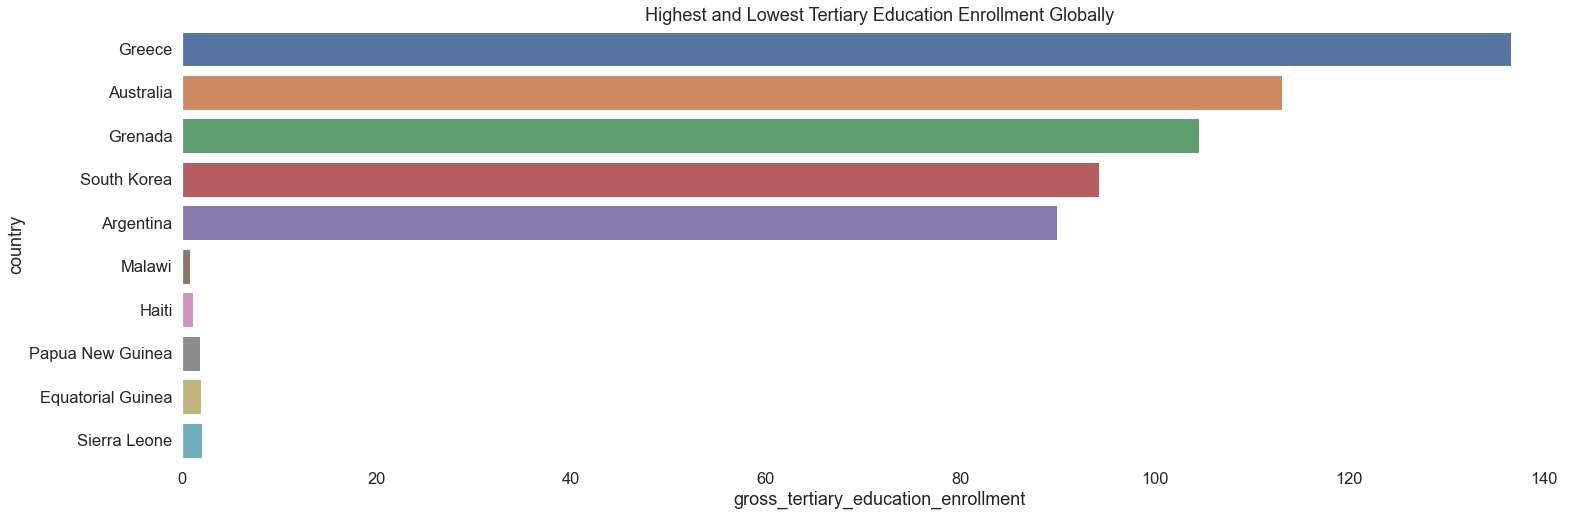

In [137]:
top_5_tertiary = df1.nlargest(5, 'gross_tertiary_education_enrollment')[['country', 'gross_tertiary_education_enrollment']]
bottom_5_tertiary = df1.nsmallest(5, 'gross_tertiary_education_enrollment')[['country', 'gross_tertiary_education_enrollment']]
top_bottom_oosr = pd.concat([top_5_tertiary, bottom_5_tertiary])

sns.barplot(x='gross_tertiary_education_enrollment', y='country', data=top_bottom_oosr).set(title='Highest and Lowest Tertiary Education Enrollment Globally')

**MODELS**

For the first model we're going to try XGBoost.

The question we're trying to address is: What are the key factors that predict higher education completion? 

In [138]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country                                  201 non-null    object 
 1   region                                   201 non-null    object 
 2   latitude                                 201 non-null    float64
 3   longitude                                201 non-null    float64
 4   oosr_primary_age_male                    121 non-null    float64
 5   oosr_primary_age_female                  116 non-null    float64
 6   completion_rate_primary_male             106 non-null    float64
 7   completion_rate_primary_female           106 non-null    float64
 8   primary_end_proficiency_reading          44 non-null     float64
 9   primary_end_proficiency_math             49 non-null     float64
 10  lower_secondary_end_proficiency_reading  86 non-nu

I'm going to look specifically at secondary school completion rate since there is no tertiary complation rate. Since there is not a huge difference between male and female secondary school completion rates, it makes sense to combine them into a single variable.

In [269]:
df1['avg_completion_rate_secondary'] = df1[['completion_rate_secondary_age_male', 'completion_rate_secondary_age_female']].mean(axis=1)

I'm going to remove latitude and longitude for lack of relevance, and the primary_end_proficiency in reading and math due to a high level of nulls. I'm also removing country and will one-hot encode Region.

In [283]:
xgb_subset = df1[['region', 'oosr_primary_age_male', 'oosr_primary_age_female', 'completion_rate_primary_male', 'completion_rate_primary_female', 'lower_secondary_end_proficiency_reading', 'lower_secondary_end_proficiency_math', 'youth_15_24_literacy_rate_male', 'youth_15_24_literacy_rate_female', 'birth_rate', 'gross_primary_education_enrollment', 'gross_tertiary_education_enrollment', 'unemployment_rate', 'avg_completion_rate_secondary',  'oosr_secondary_age_male', 'oosr_secondary_age_female']]

In [284]:
xgb_subset[xgb_subset==np.inf]=np.nan

xgb_subset.fillna(xgb_subset.mean(), inplace=True)

In [285]:
# separate target variable
y = xgb_subset['avg_completion_rate_secondary']
X = xgb_subset.drop('avg_completion_rate_secondary', axis=1)

In [286]:
# one hot encode region
X = pd.get_dummies(X, columns=['region'])

In [287]:
#normalizing
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [288]:
# convert back to df
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

In [289]:
# assign normalized X 
y = xgb_subset['avg_completion_rate_secondary']
X = X_normalized 

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [290]:
# had issue with NaNs in y_train
#train_df = pd.concat([X_train, y_train], axis=1)
#train_df = train_df.dropna(subset=['avg_completion_rate_secondary'])

#X_train = train_df.drop('avg_completion_rate_secondary', axis=1)
#y_train = train_df['avg_completion_rate_secondary']

In [291]:
# remove NaNs from y_test
#test_df = pd.concat([X_test, y_test], axis=1)
#test_df_cleaned = test_df.dropna(subset=['avg_completion_rate_secondary'])

# separate back into X and y
#X_test = test_df_cleaned.drop('avg_completion_rate_secondary', axis=1)
#y_test = test_df_cleaned['avg_completion_rate_secondary']

In [292]:
model = xgb.XGBRegressor()

In [293]:
# train
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [294]:
# make predictions on test set
predictions = model.predict(X_test)

In [295]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 72.08827754524987
R-squared: 0.8129688603172294


<Figure size 720x432 with 0 Axes>

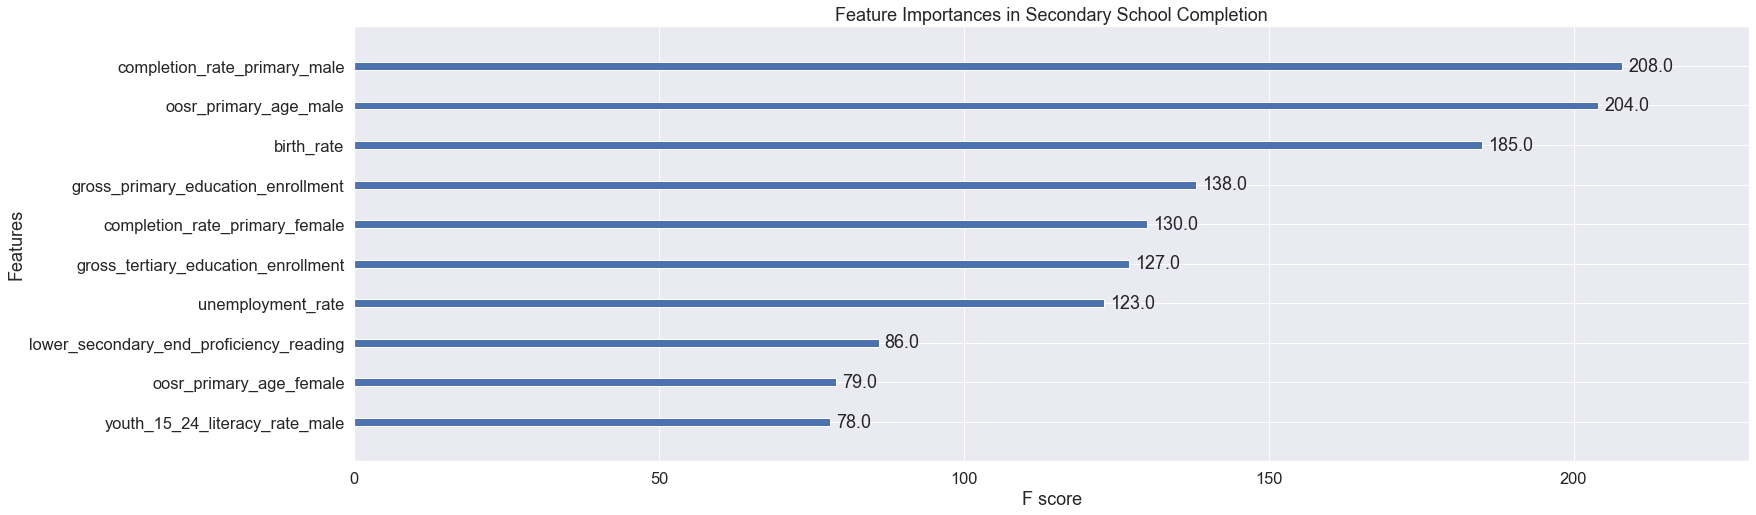

In [317]:
# plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('Feature Importances in Secondary School Completion')
plt.show()

**RANDOM FOREST**

In [299]:
rf_subset =  df1[['region', 'oosr_primary_age_male', 'oosr_primary_age_female', 'completion_rate_primary_male', 'completion_rate_primary_female', 'lower_secondary_end_proficiency_reading', 'lower_secondary_end_proficiency_math', 'youth_15_24_literacy_rate_male', 'youth_15_24_literacy_rate_female', 'birth_rate', 'gross_primary_education_enrollment', 'gross_tertiary_education_enrollment', 'unemployment_rate', 'avg_completion_rate_secondary',  'oosr_secondary_age_male', 'oosr_secondary_age_female']]

In [300]:
rf_subset[rf_subset==np.inf]=np.nan

rf_subset.fillna(rf_subset.mean(), inplace=True)

In [301]:
# separate target variable
y = rf_subset['avg_completion_rate_secondary']
X = rf_subset.drop('avg_completion_rate_secondary', axis=1)

In [302]:
# one hot encode region
X = pd.get_dummies(X, columns=['region'])

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [304]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [305]:
y_pred = rf_model.predict(X_test)

In [306]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 68.5603759640995
R-squared (R2): 0.8221219081618949


Text(0.5, 1.0, 'Feature Importance in Predicting Secondary School Completion')

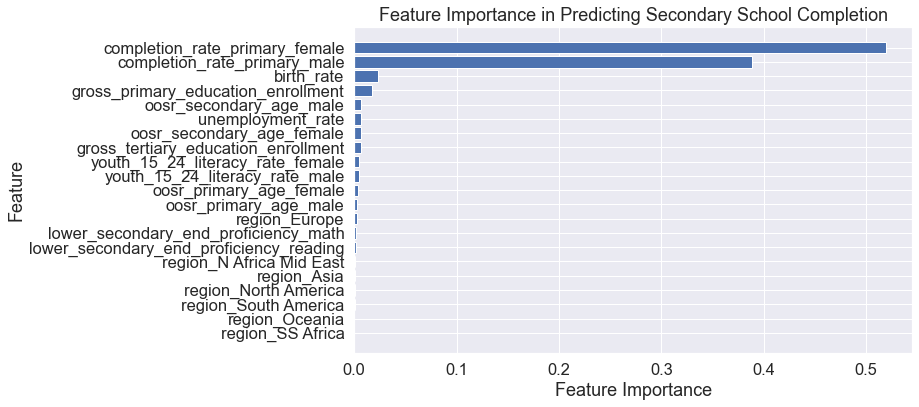

In [316]:
features = X_train.columns

feature_importance = rf_model.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 6)) 
plt.barh(range(len(features)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(features)), [features[i] for i in sorted_idx])  # Use yticks for feature names
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Secondary School Completion')

**CONCLUSIONS**

Both of these models performed pretty well, but the random forest results were less useful. Both isolated primary school completion as the main predictor of secondary school completion, which is not surprising. The XGboost also isolated birth rate as an important predictor, and we can recall that birth rates are strongly negatively correlated to school completion. 